In [1]:
# import bibliotek
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import torch

In [2]:
# wczytywanie danych
test = pd.read_csv("../data/raw/emotion_test.csv")

In [3]:
# czyszczenie tekstu
def clean_tweet(text):
    import re
    text = text.lower()
    text = re.sub(r"https?://\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return text.strip()

test['clean_text'] = test['text'].apply(clean_tweet)

In [4]:
# wektoryzacja
from sklearn.feature_extraction.text import TfidfVectorizer

import joblib
tfidf = joblib.load("../models/tfidf_vectorizer.joblib")

X_test = tfidf.transform(test['clean_text'])
y_test = test['label']

In [6]:
# wczytywanie modeli
lr_model = joblib.load("../models/logistic_regression.joblib")

from tensorflow.keras.models import load_model
nn_model = load_model("../models/nn_model.h5")

from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
transformer_model = AutoModelForSequenceClassification.from_pretrained("../models/transformer_model")

transformer_model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [7]:
# predykcje
y_pred_lr = lr_model.predict(X_test)

y_pred_nn = nn_model.predict(X_test).argmax(axis=1)

def predict_transformer(texts, model, tokenizer, device='cpu', max_length=128):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    inputs = {k:v.to(device) for k,v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    return logits.argmax(dim=1).cpu().numpy()

y_pred_tr = predict_transformer(test['clean_text'].tolist(), transformer_model, tokenizer)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


--- Wyniki dla modelu: Logistic Regression ---
Accuracy: 0.6199859254046446
              precision    recall  f1-score   support

           0       0.56      0.92      0.70       558
           1       0.75      0.42      0.54       358
           2       0.84      0.13      0.23       123
           3       0.70      0.53      0.60       382

    accuracy                           0.62      1421
   macro avg       0.71      0.50      0.52      1421
weighted avg       0.67      0.62      0.59      1421



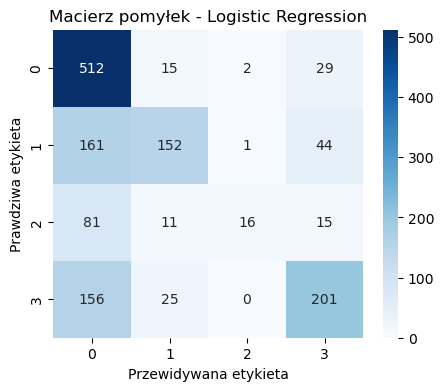

--- Wyniki dla modelu: Neural Network ---
Accuracy: 0.6460239268121042
              precision    recall  f1-score   support

           0       0.70      0.74      0.72       558
           1       0.62      0.66      0.64       358
           2       0.42      0.37      0.39       123
           3       0.65      0.58      0.61       382

    accuracy                           0.65      1421
   macro avg       0.60      0.59      0.59      1421
weighted avg       0.64      0.65      0.64      1421



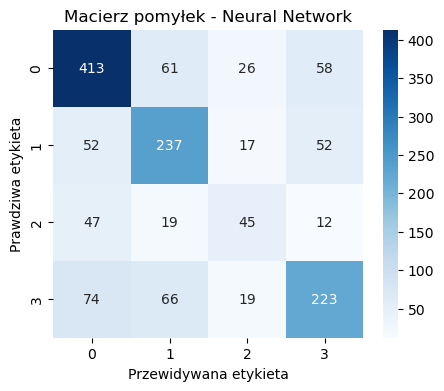

--- Wyniki dla modelu: Transformer ---
Accuracy: 0.7931034482758621
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       558
           1       0.81      0.82      0.81       358
           2       0.58      0.57      0.58       123
           3       0.78      0.78      0.78       382

    accuracy                           0.79      1421
   macro avg       0.75      0.75      0.75      1421
weighted avg       0.79      0.79      0.79      1421



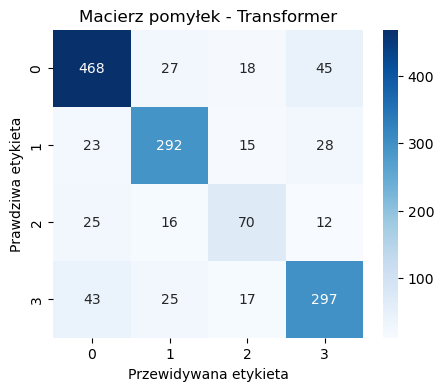

In [8]:
# wyniki
def print_eval(y_true, y_pred, model_name):
    print(f"--- Wyniki dla modelu: {model_name} ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Macierz pomyłek - {model_name}")
    plt.xlabel("Przewidywana etykieta")
    plt.ylabel("Prawdziwa etykieta")
    plt.show()


print_eval(y_test, y_pred_lr, "Logistic Regression")
print_eval(y_test, y_pred_nn, "Neural Network")
print_eval(y_test, y_pred_tr, "Transformer")

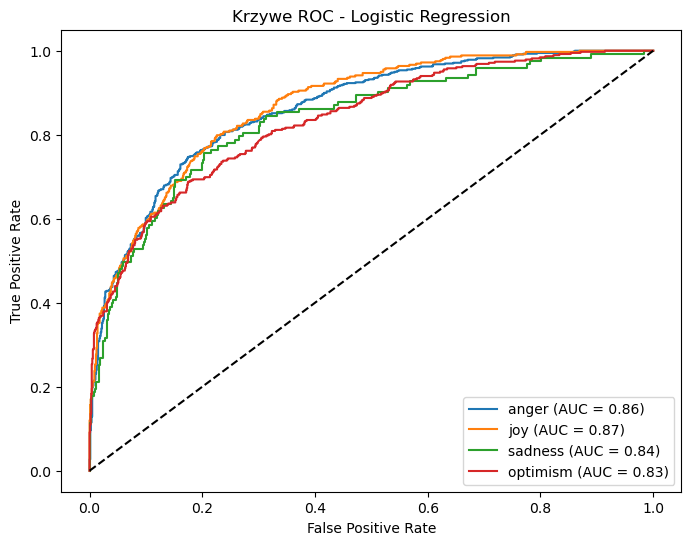

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


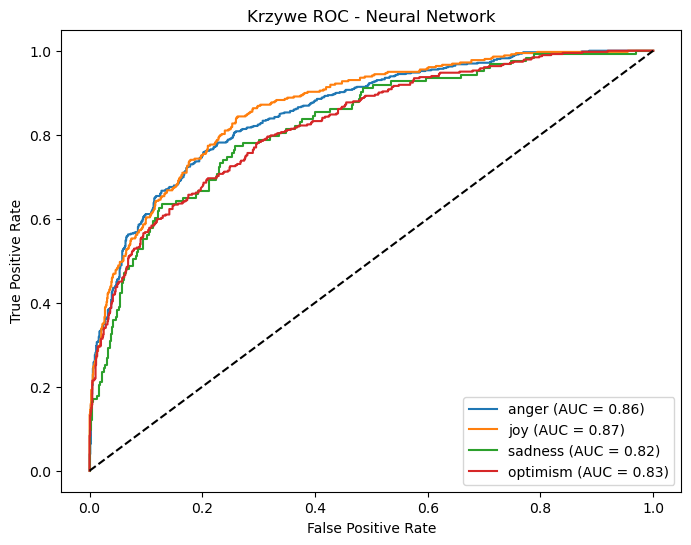

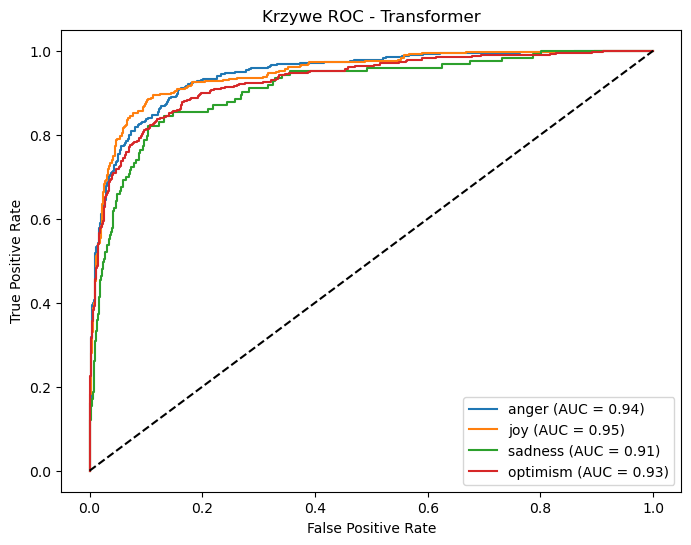

In [11]:
# krzywa ROC
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def plot_roc(y_true, y_pred_proba, class_names, model_name):
    # Binarizujemy etykiety (multi-klasa)
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

    plt.figure(figsize=(8,6))
    
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Krzywe ROC - {model_name}")
    plt.legend(loc="lower right")
    plt.show()

class_names = ['anger', 'joy', 'sadness', 'optimism']

y_pred_lr_proba = lr_model.predict_proba(X_test)
plot_roc(y_test, y_pred_lr_proba, class_names, "Logistic Regression")

y_pred_nn_proba = nn_model.predict(X_test)
plot_roc(y_test, y_pred_nn_proba, class_names, "Neural Network")

import torch
import torch.nn.functional as F

def get_transformer_probas(texts, model, tokenizer, device='cpu', max_length=128):
    model.to(device)
    model.eval()
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1).cpu().numpy()
    return probs

y_pred_tr_proba = get_transformer_probas(test['clean_text'].tolist(), transformer_model, tokenizer)
plot_roc(y_test, y_pred_tr_proba, class_names, "Transformer")

In [ ]:
# Wnioski: najlepszy wynik uzyskał transformer, następnie sieć neuronowa, a najgorzej wypadła regresja logistyczna